# T4: Neural IBM1 with collocations and latent gate

Neural IBM 1 with additional stochastic collocations (Section 2.3 of the notebook).

Here we made the collocation variable $s$ continuous. You can interpret $S$ as a random variable over gate values.

In [88]:
# first run a few imports:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from pprint import pprint
import pickle
from utils import smart_reader, bitext_reader
from vocabulary import OrderedCounter, Vocabulary 
from utils import iterate_minibatches, prepare_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [89]:
# the paths to our training and validation data, English side
train_e_path = 'data/training/hansards.36.2.e.gz'
train_f_path = 'data/training/hansards.36.2.f.gz'
dev_e_path = 'data/validation/dev.e.gz'
dev_f_path = 'data/validation/dev.f.gz'
dev_wa = 'data/validation/dev.wa.nonullalign'
test_e_path = 'data/test/test.e.gz'
test_f_path = 'data/test/test.f.gz'
test_wa = 'data/test/test.wa.nonullalign'

These are the vocabularies that we use further on.

In [90]:
# Using only 1000 words will result in many UNKs, but
# it will make training a lot faster. 
# If you have a fast computer, a GPU, or a lot of time,
# try with 10000 instead.
max_tokens=1000

corpus_e = smart_reader(train_e_path)    
vocabulary_e = Vocabulary(corpus=corpus_e, max_tokens=max_tokens)
pickle.dump(vocabulary_e, open("vocabulary_e.pkl", mode="wb"))

corpus_f = smart_reader(train_f_path)    
vocabulary_f = Vocabulary(corpus=corpus_f, max_tokens=max_tokens)
pickle.dump(vocabulary_f, open("vocabulary_f.pkl", mode="wb"))

## T4 model

We will import the `NeuralIBM1Model` (rewritten as a VAE) from `T4.py` and `NeuralIBM1Trainer` from `T4trainer.py`. But to show the code, we include it here (Have a look at the code. It is amazing. Really good code.):

In [ ]:
import numpy as np
import tensorflow as tf
from aer import read_naacl_alignments, AERSufficientStatistics
from utils import iterate_minibatches, prepare_data
import scipy as sp

# for TF 1.1
import tensorflow
try:
    from tensorflow.contrib.keras.initializers import glorot_uniform
except:  # for TF 1.0
    from tensorflow.contrib.layers import xavier_initializer as glorot_uniform

class NeuralIBM1Model:
    """Our Neural IBM1 model."""

    def __init__(self, batch_size=8,
               x_vocabulary=None, y_vocabulary=None,
               emb_dim=32, mlp_dim=64,
               session=None):

        self.batch_size = batch_size
        self.emb_dim = emb_dim

        self.mlp_dim = mlp_dim

        self.x_vocabulary = x_vocabulary
        self.y_vocabulary = y_vocabulary
        self.x_vocabulary_size = len(x_vocabulary)
        self.y_vocabulary_size = len(y_vocabulary)

        self._create_placeholders()
        self._create_weights()
        self._build_model()

        self.saver = tf.train.Saver()
        self.session = session

    def _create_placeholders(self):
        """We define placeholders to feed the data to TensorFlow."""
        # "None" means the batches may have a variable maximum length.
        self.x  = tf.placeholder(tf.int64, shape=[None, None],
                                 name = "english")
        self.yp = tf.placeholder(tf.int64, shape=[None, None],
                                 name = "prev_french")
        self.y  = tf.placeholder(tf.int64, shape=[None, None],
                                 name = "french")

    def _create_weights(self):
        """Create weights for the model."""
        # TIM: we need to double the input embedding size if the mode is concat.
        emb_dim = self.emb_dim

        with tf.variable_scope("MLP") as scope:
            # first layer for t
            self.mlp_Wt_ = tf.get_variable(
            name="Wt_", initializer=glorot_uniform(),
            shape=[emb_dim, self.mlp_dim])

            self.mlp_bt_ = tf.get_variable(
            name="bt_", initializer=tf.zeros_initializer(),
            shape=[self.mlp_dim])

            # first layer for i and s
            self.mlp_Wis_ = tf.get_variable(
            name="Wis_", initializer=glorot_uniform(),
            shape=[emb_dim, self.mlp_dim])

            self.mlp_bis_ = tf.get_variable(
            name="bis_", initializer=tf.zeros_initializer(),
            shape=[self.mlp_dim])

            # layer for translation P(F|E)
            self.mlp_W_t = tf.get_variable(
            name="W_t", initializer=glorot_uniform(),
            shape=[self.mlp_dim, self.y_vocabulary_size])

            self.mlp_b_t = tf.get_variable(
            name="b_t", initializer=tf.zeros_initializer(),
            shape=[self.y_vocabulary_size])

            # layer for insertion P(F|Fprev)
            self.mlp_W_i = tf.get_variable(
            name="W_i", initializer=glorot_uniform(),
            shape=[self.mlp_dim, self.y_vocabulary_size])

            self.mlp_b_i = tf.get_variable(
            name="b_i", initializer=tf.zeros_initializer(),
            shape=[self.y_vocabulary_size])

            # layer for laten gate S, P(S|Fprev)
            self.a_W = tf.get_variable(
            name="a_W", initializer=tf.random_normal_initializer(),
            shape=[self.mlp_dim, 1])

            self.a_b = tf.get_variable(
            name="a_b", initializer=tf.random_normal_initializer(),
            shape=[1])

            self.b_W = tf.get_variable(
            name="b_W", initializer=tf.random_normal_initializer(),
            shape=[self.mlp_dim, 1])

            self.b_b = tf.get_variable(
            name="b_b", initializer=tf.random_normal_initializer(),
            shape=[1])

            self.alpha_W = tf.get_variable(
            name="alpha_W", initializer=tf.random_normal_initializer(),
            shape=[self.mlp_dim, 1])

            self.alpha_b = tf.get_variable(
            name="alpha_b", initializer=tf.random_normal_initializer(),
            shape=[1])

            self.beta_W = tf.get_variable(
            name="beta_W", initializer=tf.random_normal_initializer(),
            shape=[self.mlp_dim, 1])

            self.beta_b = tf.get_variable(
            name="beta_b", initializer=tf.random_normal_initializer(),
            shape=[1])
    
    def save(self, session, path="model.ckpt"):
        """Saves the model."""
        return self.saver.save(session, path)

    def _build_model(self):
        """Builds the computational graph for our model."""

        # 1. Let's create a (source) word embeddings matrix.
        # These are trainable parameters, so we use tf.get_variable.
        # Shape: [Vx, emb_dim] where Vx is the source vocabulary size
        x_embeddings = tf.get_variable(
          name="x_embeddings", initializer=tf.random_uniform_initializer(),
          shape=[self.x_vocabulary_size, self.emb_dim])
        y_embeddings = tf.get_variable(
          name="y_embeddings", initializer=tf.random_uniform_initializer(),
          shape=[self.y_vocabulary_size, self.emb_dim])

        emb_dim = self.emb_dim

        # Now we start defining our graph.

        # ###############################################
        # This is the **inference** network q_\phi(Z | x)
        #
        #  it predicts for each x a d-dimensional vector of means and a vector of (log) variances
        #  it does so from x's 1-hot encoding
        #  thus the first step is to embed x

        # first we need to know some sizes from the current input data
        batch_size = tf.shape(self.x)[0]
        longest_x = tf.shape(self.x)[1]  # longest M
        longest_y = tf.shape(self.y)[1]  # longest N

        # Input yp
        twos = 2*tf.ones([tf.shape(self.y)[0], 1], tf.int64) # prepend all the sentences with '2', the code for <S>
        yp = tf.concat([twos, self.y[:,:-1]], axis=1, name='concat-twos')
        self.y_p = yp
        yp_embedded = tf.nn.embedding_lookup(y_embeddings, yp) # Shape: [B, N, emb_dim]
        self.yp_embedded = yp_embedded

        # Input x
        x_embedded = tf.nn.embedding_lookup(x_embeddings, self.x) # Shape: [B, M, emb_dim]


        # It's also useful to have masks that indicate what
        # values of our batch we should ignore.
        # Masks have the same shape as our inputs, and contain
        # 1.0 where there is a value, and 0.0 where there is padding.
        x_mask  = tf.cast(tf.sign(self.x), tf.float32)    # Shape: [B, M]
        y_mask  = tf.cast(tf.sign(self.y), tf.float32)    # Shape: [B, N]
        x_len   = tf.reduce_sum(tf.sign(self.x), axis=1)  # Shape: [B]
        y_len   = tf.reduce_sum(tf.sign(self.y), axis=1)  # Shape: [B]

        # 2.a Build an alignment model P(A | X, M, N)

        # This just gives you 1/length_x (already including NULL) per sample.
        # i.e. the lengths are the same for each word y_1 .. y_N.
        lengths  = tf.expand_dims(x_len, -1)  # Shape: [B, 1]
        pa_x     = tf.div(x_mask, tf.cast(lengths, tf.float32))   # Shape: [B, M]

        # We now have a matrix with 1/M values.
        # For a batch of 2 setencnes, with lengths 2 and 3:
        #
        #  pa_x = [[1/2 1/2   0]
        #          [1/3 1/3 1/3]]
        #
        # But later we will need it N times. So we repeat (=tile) this
        # matrix N times, and for that we create a new dimension
        # in between the current ones (dimension 1).
        pa_x  = tf.expand_dims(pa_x, 1)  # Shape: [B, 1, M]

        #  pa_x = [[[1/2 1/2   0]]
        #          [[1/3 1/3 1/3]]]
        # Note the extra brackets.

        # Now we perform the tiling:
        pa_x  = tf.tile(pa_x, [1, longest_y, 1])  # [B, N, M]

        # pa_x = tf.tile(y_embedded, [1, 1, longest_y])

        # Result:
        #  pa_x = [[[1/2 1/2   0]
        #           [1/2 1/2   0]]
        #           [[1/3 1/3 1/3]
        #           [1/3 1/3 1/3]]]

        # The MLP

        # This is for P(F|E), translation t
        mlp_input = tf.reshape(x_embedded, [batch_size * longest_x, emb_dim], name='x-emb-reshape')
        h_t = tf.matmul(mlp_input, self.mlp_Wt_, name='x1') + self.mlp_bt_ # Shape [B*M, emb_dim]
        h_t  = tf.tanh(h_t)
        h_t = tf.matmul(h_t, self.mlp_W_t, name='x2') + self.mlp_b_t # Shape [B*M, emb_dim]
        # Now we perform a softmax which operates on a per-row basis.
        py_xa = tf.nn.softmax(h_t)
        # This is P(F|E)
        py_xa = tf.reshape(py_xa, [batch_size, longest_x, self.y_vocabulary_size], name='py_xa-emb-reshape') # Shape [B, M, Vy]

        # This is for P(F|Fprev) and P(C|Fprev), insertion i and collocation c
        # Note: Shared first layer!
        mlp_input = tf.reshape(yp_embedded, [batch_size * longest_y, emb_dim], name='yp-emb-reshape')
        h_is = tf.matmul(mlp_input, self.mlp_Wis_, name='y1') + self.mlp_bis_ # Shape [B*N, emb_dim]
        h_is  = tf.tanh(h_is)
        # This is P(F|Fprev) insertion i
        h_i = tf.matmul(h_is, self.mlp_W_i, name='y2') + self.mlp_b_i # Shape [B*N, emb_dim]
        py_y  = tf.nn.softmax(h_i) # Shape: [B*N, Vy]
        py_y = tf.reshape(py_y, [batch_size, longest_y, self.y_vocabulary_size], name='py_y-emb-reshape') # Shape [B, N, Vy]

        # This for the prior p(Z) = Beta(a,b)
        a = tf.matmul(h_is, self.a_W) + self.a_b  # [B*M, 1]
        a = tf.exp(a)
        a = tf.squeeze(a)
        b = tf.matmul(h_is, self.b_W) + self.b_b  # [B*M, 1]
        b = tf.exp(b)
        b = tf.squeeze(b)
        # This is for the approxiation of the posterior p(Z|X) using Kuma(alpha, beta)
        alpha = tf.matmul(h_is, self.alpha_W) + self.alpha_b  # [B*N, 1]
        alpha = tf.exp(alpha)
        alpha = tf.squeeze(alpha)
        self.alpha = tf.reshape(alpha, [batch_size, longest_y])
        beta = tf.matmul(h_is, self.beta_W) + self.beta_b  # [B*N, 1]
        beta = tf.exp(beta)
        beta = tf.squeeze(beta)
        self.beta = tf.reshape(beta, [batch_size, longest_y])



        # ##############################################
        # This is the *generative* network
        #  it conditions on our sampled z to predict the parameters of a Categorical over the vocabulary


        # #########################################################
        # Prediction
        #
        # Note that while training is stochastic (we sample z by sampling epsilon
        #  and computing Z= mu(x) + epsilon * sigma(x)
        #  for predicted mu(x) and sigma(x)
        #
        # we will simplify *predictions* by making them deterministic
        #  that is, for *predictions only* we will pretend z can be represented by
        #  the predicted mean, i.e. Z=mu(x)
        #
        #  Why is this a simplification?
        #  * once we get an assignment to Z, the generative network applies
        #    a nonlinear layers before predicting the final softmax
        #    this means that
        #      E[softmax(f_\theta(z))\ != softmax(f_\theta(E[z]))
        #    where E[z] = mu(x)
        #
        #  The principled thing to do is to sample a few assignments (e.g. 100)
        #   and run the generative model on each assignment
        #   then use a probabilistic disambiguation rule (e.g. most-probable-sample,
        #   or MBR, etc.).
        #  Here instead we simply take the mean as a hopefully good approximation.


        # 2.c Marginalise alignments: \sum_a P(a|x) P(Y|x,a)

        # Here comes a rather fancy matrix multiplication.
        # Note that tf.matmul is defined to do a matrix multiplication
        # [N, M] @ [M, Vy] for each item in the first dimension B.
        # So in the final result we have B matrices [N, Vy], i.e. [B, N, Vy].
        #
        # We matrix-multiply:
        #   pa_x       Shape: [B, N, *M*]
        #       pa_x       Shape: [B, N, *N*M*]
        # and
        #   py_xa      Shape: [B, *M*, Vy]
        #       py_xa      Shape: [B, *N*M*, Vy]
        # to get
        #   py_x  Shape: [B, N, Vy]
        #
        # Note: P(y|x) = prod_j p(y_j|x) = prod_j sum_aj p(aj|m)p(y_j|x_aj)
        py_x = tf.matmul(pa_x, py_xa, name='3')  # Shape: [B, N, Vy]


        # ###############################################
        # This is the MC estimate of the (negative) ELBO (because we do minimisation here)
        #  it includes the MC estimate of the negative log likelihood

        # Sample gate value s. note weird tf construction for beta disrtb.
        # see https://www.tensorflow.org/api_docs/python/tf/contrib/distributions/Beta
        # Beta = tf.contrib.distributions.Beta(a,b) # constructs distributions same shape as a (and b)
        # s = Beta.sample() # generates a single sample for each of the distributions



        euler = 0.5772156649
        # approx = tf.add_n([tf.reciprocal(m + alpha*beta) * Beta(m * tf.reciprocal(alpha), beta) for m in range(1,10)])
        alpha = alpha + 0.0001 # to avoid division by 0
        beta = beta + 0.0001 # to avoid division by 0
        approx = tf.add_n([tf.reciprocal(m + alpha*beta) * tf.exp(tf.lbeta([m*tf.reciprocal(alpha), beta])) for m in range(1,10)])    
        first = tf.multiply(tf.div(alpha - a, alpha), -euler - tf.digamma(beta) - tf.reciprocal(beta))
        self.first = first
        second = tf.log(tf.multiply(alpha, beta)) + tf.lbeta([alpha, beta]) - tf.multiply(beta - 1, tf.reciprocal(beta))
        self.second = second
        third = tf.multiply(tf.multiply(b - 1, beta), approx)
        self.third = third
        kl = first + second + third
        kl = tf.reshape(kl, tf.shape(self.y), name='KL-reshape')  # reshape back to [B, N]
        self.kl = tf.reduce_mean(tf.reduce_sum(kl * y_mask, axis=1), axis=0)

        # Our sampled S is a **deterministic** function of the random noise (u)
        # this pushes all sources of non-determinism out of the computational graph
        # which is very convenient
        # In formula: s = (1-u^{1/alpha})^{1/beta}
        u = tf.random_uniform(tf.shape(alpha), minval=0, maxval=1, dtype=tf.float32)  # [B*N]
        s = tf.pow(tf.add(-tf.pow(u, tf.reciprocal(alpha)), 1), tf.reciprocal(beta)) # hopefully this works
        # Read the equation in Theory 2.2 carefully. Then you will see that this is correct.
        s = tf.reshape(s, [batch_size, longest_y], name='s_reshape')
        s_tiled = tf.expand_dims(s, 2) # Shape: [B, N, 1]
        s_tiled = tf.tile(s_tiled, [1, 1, self.y_vocabulary_size]) # Shape: [B, N, Vy]

        # Here we marginalise over S
        py_x = tf.multiply(s_tiled, py_x, name='s1') + tf.multiply(1-s_tiled, py_y, name='s2') # Shape [B, N, Vy]

        # This calculates the accuracy, i.e. how many predictions we got right.
        predictions = tf.argmax(py_x, axis=2)
        acc = tf.equal(predictions, self.y)
        acc = tf.cast(acc, tf.float32) * y_mask
        acc_correct = tf.reduce_sum(acc)
        acc_total = tf.reduce_sum(y_mask)
        acc = acc_correct / acc_total

        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=tf.reshape(self.y, [-1], name='y_reshape'),
          logits=tf.log(tf.reshape(py_x,[batch_size * longest_y, self.y_vocabulary_size], name='lastfucker')),
          name="logits"
        )
        cross_entropy = tf.reshape(cross_entropy, [batch_size, longest_y], name='ce-reshape')
        cross_entropy = tf.reduce_sum(cross_entropy * y_mask, axis=1)
        self.ce = tf.reduce_mean(cross_entropy, axis=0)

        # The total loss is the negative MC estimate of the ELBO
        self.loss = self.ce + self.kl

        self.pa_x = pa_x
        self.py_x = py_x
        self.py_y = py_y
        self.py_xa = py_xa
        self.s = s
        self.predictions = predictions
        self.accuracy = acc
        self.accuracy_correct = tf.cast(acc_correct, tf.int64)
        self.accuracy_total = tf.cast(acc_total, tf.int64)


    def evaluate(self, data, ref_alignments, batch_size=4):
        """Evaluate the model on a data set."""

        ref_align = read_naacl_alignments(ref_alignments)

        ref_iterator = iter(ref_align)
        metric = AERSufficientStatistics()
        accuracy_correct = 0
        accuracy_total = 0

        for batch_id, batch in enumerate(iterate_minibatches(data, batch_size=batch_size)):
            x, y = prepare_data(batch, self.x_vocabulary, self.y_vocabulary)
            y_len = np.sum(np.sign(y), axis=1, dtype="int64")

            align, prob, acc_correct, acc_total = self.get_viterbi(x, y)
            accuracy_correct += acc_correct
            accuracy_total += acc_total

            for alignment, N, (sure, probable) in zip(align, y_len, ref_iterator):
                # the evaluation ignores NULL links, so we discard them
                # j is 1-based in the naacl format
                pred = set((aj, j) for j, aj in enumerate(alignment[:N], 1) if aj > 0)
                metric.update(sure=sure, probable=probable, predicted=pred)

        accuracy = accuracy_correct / float(accuracy_total)
        return metric.aer(), accuracy


    def get_viterbi(self, x, y):
        """Returns the Viterbi alignment for (x, y)"""

        feed_dict = {
          self.x: x, # English
          self.y: y, # French
        }

        # run model on this input
        py_xa, py_y, s, acc_correct, acc_total, alpha, beta = self.session.run(
          [self.py_xa,
           self.py_y,
           self.s,
           self.accuracy_correct, 
           self.accuracy_total,
           self.alpha,
           self.beta],
           feed_dict=feed_dict)

        # things to return
        batch_size, longest_y = y.shape
        _, longest_x = x.shape
        alignments = np.zeros((batch_size, longest_y), dtype="int64")
        probabilities = np.zeros((batch_size, longest_y), dtype="float32")

        for b, sentence in enumerate(y):
            for j, french_word in enumerate(sentence):
                if french_word == 0:  # Padding
                    break
                fprev = j
                alphaj = alpha[b,j] + 0.0001
                betaj = beta[b,j] + 0.0001
                # if b in range(20): print(sj)
                # Here we use the expectation of a Kuma(alpha, beta) distr
                # with our estimated alpha and beta:
                # s = E[S] = beta*Gamma(1+1/alpha)Gamma(beta) / Gamma(1+1/alpha+beta)
                sj = (betaj*sp.special.gamma(1+1/(alphaj))*sp.special.gamma(betaj)) / sp.special.gamma(1+1/(alphaj)+betaj)
                c = int(np.random.uniform() < sj) # sample c ~ Bernouilli(sj)
                if c == 0: # then we align
                    probs = py_xa[b, : , y[b,j]] # y[b,j] means only the word f_j in the sentence b
                    a_j = probs.argmax()
                    p_j = probs[a_j]
                if c == 1: # then we `insert` (i.e. NULL align - see NLP2 blog post)
                    # if b in range(20): print('Null aligned')
                    a_j = 0 # NULL align
                    p_j = 1 # not important

                alignments[b, j] = a_j
                probabilities[b, j] = p_j


    return alignments, probabilities, acc_correct, acc_total


In [164]:
from T4 import NeuralIBM1Model
from T4trainer import NeuralIBM1Trainer

#### On 10k sentences

In [166]:
tf.reset_default_graph()


with tf.Session() as sess:

    # some hyper-parameters
    # tweak them as you wish
    batch_size=10  # on CPU, use something much smaller e.g. 1-16
    max_length=30
    lr = 0.001
    lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
    emb_dim = 64
    mlp_dim = 128

    # our model
    model = NeuralIBM1Model(
        x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
        batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)

    # our trainer
    trainer = NeuralIBM1Trainer(
        model, train_e_path, train_f_path, 
        dev_e_path, dev_f_path, dev_wa,
        test_e_path, test_f_path, test_wa,
        num_epochs=10, batch_size=batch_size, 
        max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess,
        max_num=10000) # small training corpus just to make testing new code easier

    # now first TF needs to initialize all the variables
    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())

    # now we can start training!
    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_ELBOs, dev_ELBOs = results

Training with B=10 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss -4043.429443 ce 67.954430 kl -4111.383789 accuracy 0.09 lr 0.001000
Iter   200 loss -4766.895020 ce 78.843971 kl -4845.738770 accuracy 0.16 lr 0.001000
Iter   300 loss -3705.818359 ce 53.314465 kl -3759.132812 accuracy 0.25 lr 0.001000
Iter   400 loss -5774.806641 ce 98.848389 kl -5873.655273 accuracy 0.15 lr 0.001000
Iter   500 loss -4424.308594 ce 69.040314 kl -4493.349121 accuracy 0.20 lr 0.001000
Iter   600 loss -5059.851562 ce 79.610077 kl -5139.461426 accuracy 0.21 lr 0.001000
Iter   700 loss -4603.071289 ce 66.492516 kl -4669.563965 accuracy 0.21 lr 0.001000


/Users/daan/Documents/Logic/NLP2/part3/Variational_AutoEncoders/T4.py:440: RuntimeWarning: invalid value encountered in double_scalars
  sj = (betaj*sp.special.gamma(1+1/(alphaj))*sp.special.gamma(betaj)) / sp.special.gamma(1+1/(alphaj)+betaj)


Epoch 1 loss -4038.116148 accuracy 0.19 val_aer 0.68 val_acc 0.19
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Iter   100 loss -4049.175049 ce 62.392345 kl -4111.567383 accuracy 0.09 lr 0.001000
Iter   200 loss -4770.917480 ce 74.866531 kl -4845.784180 accuracy 0.15 lr 0.001000
Iter   300 loss -3708.629639 ce 50.525105 kl -3759.154785 accuracy 0.23 lr 0.001000
Iter   400 loss -5778.699707 ce 94.979614 kl -5873.679199 accuracy 0.15 lr 0.001000
Iter   500 loss -4428.931641 ce 64.432449 kl -4493.364258 accuracy 0.20 lr 0.001000
Iter   600 loss -5062.996582 ce 76.474510 kl -5139.471191 accuracy 0.21 lr 0.001000
Iter   700 loss -4607.411133 ce 62.164143 kl -4669.575195 accuracy 0.22 lr 0.001000
Epoch 2 loss -4175.350656 accuracy 0.20 val_aer 0.52 val_acc 0.19
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Iter   100 loss -4058.460938 ce 53.114754 

### Plots

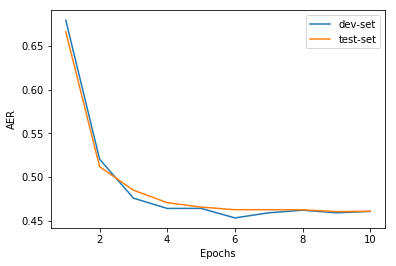

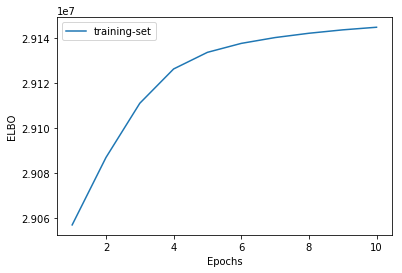

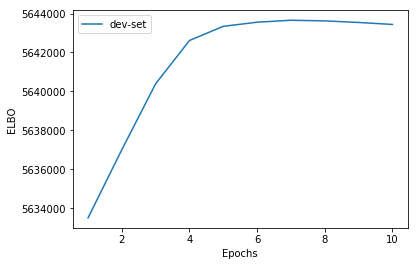

In [167]:
# plotting
import matplotlib.pyplot as plt

handles = []
ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('AER')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(train_ELBOs)+1), train_ELBOs, label='training-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(dev_ELBOs)+1), dev_ELBOs, label='dev-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.show()
plt.clf()

#### On 100k sentences

In [ ]:
tf.reset_default_graph()


with tf.Session() as sess:

    # some hyper-parameters
    # tweak them as you wish
    batch_size=10  # on CPU, use something much smaller e.g. 1-16
    max_length=30
    lr = 0.001
    lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
    emb_dim = 64
    mlp_dim = 128

    # our model
    model = NeuralIBM1Model(
        x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
        batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)

    # our trainer
    trainer = NeuralIBM1Trainer(
        model, train_e_path, train_f_path, 
        dev_e_path, dev_f_path, dev_wa,
        test_e_path, test_f_path, test_wa,
        num_epochs=10, batch_size=batch_size, 
        max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess,
        max_num=100000) # small training corpus just to make testing new code easier

    # now first TF needs to initialize all the variables
    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())

    # now we can start training!
    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_ELBOs, dev_ELBOs = results

Training with B=10 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss -3973.885010 ce 68.410545 kl -4042.295654 accuracy 0.09 lr 0.001000
Iter   200 loss -4767.061035 ce 78.689514 kl -4845.750488 accuracy 0.16 lr 0.001000
Iter   300 loss -3705.911133 ce 53.218483 kl -3759.129639 accuracy 0.25 lr 0.001000
Iter   400 loss -5775.269043 ce 98.391670 kl -5873.660645 accuracy 0.15 lr 0.001000
Iter   500 loss -4424.097656 ce 69.246826 kl -4493.344238 accuracy 0.20 lr 0.001000
Iter   600 loss -5060.034668 ce 79.411919 kl -5139.446777 accuracy 0.21 lr 0.001000
Iter   700 loss -4603.160156 ce 66.398285 kl -4669.558594 accuracy 0.22 lr 0.001000
Iter   800 loss -1563.177612 ce 22.714556 kl -1585.892212 accuracy 0.30 lr 0.001000
Iter   900 loss -4518.131348 ce 63.319038 kl -4581.450195 accuracy 0.26 lr 0.001000
Iter  1000 loss -5448.706543 ce 72.544449 kl -5521.250977 accuracy 0.29 lr 0.001000
Iter  1100 loss -4828.939941 ce 75.56

/Users/daan/Documents/Logic/NLP2/part3/Variational_AutoEncoders/T4.py:440: RuntimeWarning: invalid value encountered in double_scalars
  c = int(np.random.uniform() < sj) # sample c ~ Bernouilli(sj)


Epoch 1 loss -3978.860076 accuracy 0.20 val_aer 0.44 val_acc 0.18
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Iter   100 loss -4065.739258 ce 45.841331 kl -4111.580566 accuracy 0.10 lr 0.001000
Iter   200 loss -4787.428223 ce 58.363213 kl -4845.791504 accuracy 0.15 lr 0.001000
Iter   300 loss -3716.596680 ce 42.562862 kl -3759.159424 accuracy 0.24 lr 0.001000
Iter   400 loss -5790.060547 ce 83.627647 kl -5873.687988 accuracy 0.15 lr 0.001000
Iter   500 loss -4435.177246 ce 58.193531 kl -4493.370605 accuracy 0.20 lr 0.001000
Iter   600 loss -5071.927246 ce 67.548325 kl -5139.475586 accuracy 0.21 lr 0.001000
Iter   700 loss -4617.308594 ce 52.273182 kl -4669.581543 accuracy 0.22 lr 0.001000
Iter   800 loss -1574.175171 ce 11.720383 kl -1585.895508 accuracy 0.35 lr 0.001000
Iter   900 loss -4525.512695 ce 55.962963 kl -4581.475586 accuracy 0.26 lr 0.001000
Iter  1000 loss -5454.693848 ce 66.572968 kl -5521.266602 a

In [ ]:
# plotting
import matplotlib.pyplot as plt

handles = []
ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('AER')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(train_ELBOs)+1), train_ELBOs, label='training-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(dev_ELBOs)+1), dev_ELBOs, label='dev-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.show()
plt.clf()